Anchored Ensembling - Regression Example in Tensorflow
=========

This notebook runs through a slimmed down tensorflow implementation for a 1-d problem with a single layer NN. The whole thing should run in about 5 seconds on a modern laptop.

Try playing around with the following hyperparameters to get a feel for the effect they have on the predictive distribution:

init_stddev_1_w, data_noise, n_ensembles, and also different activation functions in the NN class.

You can find a more bulked out version of the NN class elsewhere in this repo, set up for the rbf NN and able to handle batches etc.


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

We'll start by generating and plotting some toy data that was used in the plots in the paper (https://arxiv.org/abs/1810.05546).

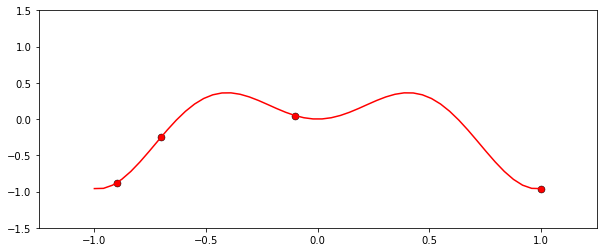

In [2]:
# create some data
X_train = np.atleast_2d([-0.9,-0.7,-0.1,1]).T
X_train = X_train
y_train = X_train * np.sin(X_train*5.)


X_ground_truth = np.atleast_2d(np.linspace(-1,1)).T
y_ground_truth = X_ground_truth * np.sin(X_ground_truth*5.)

# create validation data - here we'll just a 1-d grid
X_val = np.atleast_2d(np.linspace(-1.5, 1.5, 100)).T
y_val = np.expand_dims(X_val[:,0],1) # just dummy data

# plot data
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(X_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k',markeredgewidth=0.5)
ax.plot(X_ground_truth[:, 0], y_ground_truth, c='r')
ax.set_ylim(-1.5,1.5)
ax.set_xlim(-1.25,1.25)
plt.savefig('true.pdf')

In [3]:
y_train

array([[-0.87977711],
       [-0.24554826],
       [ 0.04794255],
       [-0.95892427]])

Now let's build the actual neural network (NN) class. An instance of each will be combined in the ensemble. The procedure is very similar to how you'd build a NN in tf. One thing we do need to carefully handle is being able to firstly initialise the NN parameters, then secondly access these values and set the regularisation around them. I've done that here by separating out the two methods, though there are other (possibly easier) ways this might be done.

In [4]:
# NN class
class NN():
    def __init__(self, x_dim, y_dim, hidden_size, init_stddev_1_w, init_stddev_1_b, 
                 init_stddev_2_w, n, learning_rate):

        # setting up as for a usual NN
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.hidden_size = hidden_size
        self.n = n
        self.learning_rate = learning_rate
        
        # set up NN
        self.inputs = tf.placeholder(tf.float64, [None, x_dim], name='inputs')
        self.y_target = tf.placeholder(tf.float64, [None, y_dim], name='target')        # set up NN
        # self.inputs_v = tf.placeholder(tf.float64, [None, x_dim], name='inputs_v')
        # self.y_target_v = tf.placeholder(tf.float64, [None, y_dim], name='target_v')
        #
        self.layer_1_w = tf.layers.Dense(hidden_size,
            activation=tf.nn.tanh, # try using tf.nn.relu, tf.erf, tf.nn.tanh etc.
            kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_1_w),
            bias_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_1_b))

        self.layer_1 = self.layer_1_w.apply(self.inputs)


        self.layer_2_w = tf.layers.Dense(hidden_size,
            activation=tf.nn.tanh, # try using tf.nn.relu, tf.erf, tf.nn.tanh etc.
            kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_1_w),
            bias_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_1_b))

        self.layer_2 = self.layer_2_w.apply(self.layer_1)

        # self.layer_3_w = tf.layers.Dense(hidden_size,
        #     activation=tf.nn.tanh, # try using tf.nn.relu, tf.erf, tf.nn.tanh etc.
        #     kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_1_w),
        #     bias_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_1_b))
        #
        # self.layer_3 = self.layer_3_w.apply(self.layer_2)

        self.output_w = tf.layers.Dense(y_dim,
            activation=None, use_bias=False,
            kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_2_w))

        # self.layer_1_w = tf.layers.Dense(hidden_size,
        #     activation=tf.nn.tanh)
        #
        # self.layer_1 = self.layer_1_w.apply(self.inputs)
        #
        #
        # self.layer_2_w = tf.layers.Dense(hidden_size,
        #     activation=tf.nn.tanh)
        #
        # self.layer_2 = self.layer_2_w.apply(self.layer_1)
        #
        # self.output_w = tf.layers.Dense(y_dim,
        #     activation=tf.nn.tanh)
        
        self.output = self.output_w.apply(self.layer_2)
        
        # set up loss and optimiser - we'll modify this later with anchoring regularisation
        self.opt_method = tf.train.AdamOptimizer(self.learning_rate)
        # self.mse_ = 1/tf.shape(self.inputs, out_type=tf.int64)[0] * tf.reduce_sum(tf.square(self.y_target - self.output))
        self.mse_ = tf.reduce_mean(tf.square(self.y_target - self.output))
        # self.mse_v = tf.reduce_mean(tf.square(self.y_target_v - self.output_v))
        self.loss_ = 1/tf.shape(self.inputs, out_type=tf.int64)[0] * tf.reduce_sum(tf.square(self.y_target - self.output))
        self.optimizer = self.opt_method.minimize(self.loss_)
        self.optimizer_mse = self.opt_method.minimize(self.mse_)
        return
    
    
    def get_weights(self, sess):
        '''method to return current params'''
        
        ops = [self.layer_1_w.kernel, self.layer_1_w.bias,self.layer_2_w.kernel, self.layer_2_w.bias, self.output_w.kernel]
        w1, b1 ,w2,b2, w = sess.run(ops)
        
        return w1, b1 ,w2, b2, w
    
    def anchor(self, sess, lambda_anchor):
        '''regularise around initialised parameters'''
        print('anchoring...')
        
        w1, b1 ,w2, b2, w   = self.get_weights(sess)

        # get initial params
        self.w1_init, self.b1_init, self.w2_init, self.b2_init, self.w_init =  w1, b1 ,w2, b2, w
        
        loss_anchor = lambda_anchor[0]*tf.reduce_sum(tf.square(self.w1_init - self.layer_1_w.kernel))
        loss_anchor += lambda_anchor[1]*tf.reduce_sum(tf.square(self.b1_init - self.layer_1_w.bias))
        loss_anchor = lambda_anchor[0]*tf.reduce_sum(tf.square(self.w2_init - self.layer_2_w.kernel))
        loss_anchor += lambda_anchor[1]*tf.reduce_sum(tf.square(self.b2_init - self.layer_2_w.bias))
        loss_anchor += lambda_anchor[2]*tf.reduce_sum(tf.square(self.w_init - self.output_w.kernel))
        
        # combine with original loss
        self.loss_ = self.loss_ + 1/tf.shape(self.inputs, out_type=tf.int64)[0] * loss_anchor 
        self.optimizer = self.opt_method.minimize(self.loss_)
        return
    
    
    def predict(self, x, sess):
        '''predict method'''
        
        feed = {self.inputs: x}
        y_pred = sess.run(self.output, feed_dict=feed)
        return y_pred


    # def train_model(self, X_train, y_train, sess):
    #     rnd = np.arange(len(X_train))
    #     np.random.shuffle(rnd)
    #     valid_idx = rnd[:int( len(X_train) / 5)]
    #     train_idx = rnd[int(len(X_train)/5) :]
    #     feed_b = {}
    #     feed_b[self.inputs] = X_train[train_idx]
    #     feed_b[self.y_target] = y_train[train_idx]
    #     feed_b[self.inputs_v] = X_train[valid_idx]
    #     feed_b[self.y_target_v] = y_train[valid_idx]
    #
    #
    #     # Get validation loss on the now initialized model
    #     mb_valid_loss = sess.run(self.loss_v, feed_dict = feed_b)
    #
    #     acc_m_losses = []
    #     last_m_losses = []
    #     md_params = sess.run(models_variables[model_idx])
    #     best_mb = {'iter': 0, 'loss': mb_valid_loss, 'params': md_params}
    #     it = 0
    #
    #     # Create mini-batch for training
    #     lb = len(tr_obs)
    #     shuffled_batch = np.arange(lb)
    #     np.random.shuffle(shuffled_batch)
    #
    #     # Run until the number of model_iter has passed from the best val loss at it on...
    #     while best_mb['iter'] > it - model_iter:
    #     # while model_training_iterations > it:
    #
    #         # update the model on each mini-batch
    #         # last_m_losses = []
    #         for idx in range(0, lb, model_batch_size):
    #             minib = shuffled_batch[idx:min(idx + minibatch_size, lb)]
    #
    #             if len(minib) != minibatch_size:
    #                 _, ml = run_model_opt_loss(model_idx, tr_obs[minib], tr_act[minib], tr_nxt_obs[minib],
    #                                            tr_rew[minib], mb_lr=mb_lr)
    #                 acc_m_losses.append(ml)
    #                 last_m_losses.append(ml)
    #             else:
    #                 pass
    #                 # print('Warning!')
    #
    #         # Check if the loss on the validation set has improved
    #         mb_valid_loss = run_model_loss(model_idx, v_obs, v_act, v_nxt_obs, v_rew)
    #         if mb_valid_loss < best_mb['loss']:
    #             best_mb['loss'] = mb_valid_loss
    #             best_mb['iter'] = it
    #             # store the parameters to the array
    #             best_mb['params'] = sess.run(models_variables[model_idx])
    #
    #         it += 1
    #         # if it>=200:
    #         #     break
    #         # print('iteration: ', it)
    #
    #     # Restore the model with the lower validation loss
    #     model_assign(model_idx, best_mb['params'])
    #
    #     print('Model:{}, iter:{} -- Old Val loss:{:.6f}  New Val loss:{:.6f} -- New Train loss:{:.6f}'.format(model_idx,
    #                                                                                                           it,
    #                                                                                                           mb_valid_loss1,
    #                                                                                                           best_mb[
    #                                                                                                               'loss'],
    #                                                                                                           np.mean(
    #                                                                                                               last_m_losses)))
    #     summary = tf.Summary()
    #     summary.value.add(tag='supplementary/m_loss', simple_value=np.mean(acc_m_losses))
    #     summary.value.add(tag='supplementary/iterations', simple_value=it)
    #     file_writer.add_summary(summary, step_count)
    #     file_writer.flush()
        

Hyperparameter settings are below. Key ones to play with are init_stddev_1_w, data_noise, and n_ensembles to get an intuitive feel for how they affect the predictive distribution. Also try playing with different activation functions in the NN class.

In [5]:
# hyperparameters
n = X_train.shape[0]
x_dim = X_train.shape[1]
y_dim = y_train.shape[1]

n_ensembles = 10
hidden_size = 40
init_stddev_1_w =  np.sqrt(1)
init_stddev_1_b = 10# init_stddev_1_w # set these equal
init_stddev_2_w = 1.0/np.sqrt(hidden_size) # normal scaling
data_noise = 0.00001 # estimated noise variance
lambda_anchor = data_noise/(np.array([init_stddev_1_w,init_stddev_1_b,init_stddev_2_w])**2)

n_epochs = 100
learning_rate = 0.001

lambda_anchor

array([1.e-05, 1.e-07, 4.e-04])

Now we will initialise a number of NNs from our NN class. It's probably tidiest to write a parent class for the whole ensemble, but I haven't done that here. In this notebook we're going to handle each individual NN in the main code.

The below code initialises and plots each NN function - you can think of these as priors.

One thing we have to be careful of is if you use the usual initialise method, tf reinitialises everything already created. This might not be desirable if you've already started training some of the NNs in the ensemble. So I've used a slightly more complex procedure where only unitialised variables are initialised.

Instructions for updating:
Please use `layer.__call__` method instead.
anchoring...
anchoring...
anchoring...
anchoring...
anchoring...
anchoring...
anchoring...
anchoring...
anchoring...
anchoring...


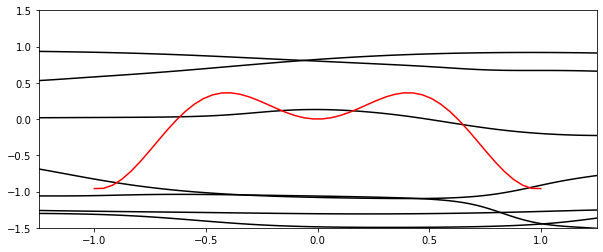

In [6]:
NNs=[]
y_prior=[]
tf.reset_default_graph()
sess = tf.Session()

# loop to initialise all ensemble members, get priors
for ens in range(0,n_ensembles):
    NNs.append(NN(x_dim, y_dim, hidden_size, 
                  init_stddev_1_w, init_stddev_1_b, init_stddev_2_w, n, learning_rate))
    
    # initialise only unitialized variables - stops overwriting ensembles already created
    global_vars = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
    
    # do regularisation now that we've created initialisations
    NNs[ens].anchor(sess, lambda_anchor)
    
    # save their priors
    y_prior.append(NNs[ens].predict(X_val, sess))
    
# plot priors
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
for ens in range(0,n_ensembles):
    ax.plot(X_val, y_prior[ens], 'k')
ax.set_ylim(-1.5,1.5)
ax.set_xlim(-1.25,1.25)
ax.plot(X_ground_truth[:, 0], y_ground_truth, c='r')
plt.savefig('prior.pdf')

Now we'll run the actual training procedure and get predictions.

# do training loop
for ens in range(0,n_ensembles):
    
    feed_b = {}
    feed_b[NNs[ens].inputs] = X_train
    feed_b[NNs[ens].y_target] = y_train
    print('\nNN:',ens)
    
    ep_ = 0
    converged = False
    # while ep_ < n_epochs:
    while not converged:
        ep_ += 1
        blank = sess.run(NNs[ens].optimizer, feed_dict=feed_b)
        if ep_ % (n_epochs/5) == 0:
            loss_mse = sess.run(NNs[ens].mse_, feed_dict=feed_b)
            loss_anch = sess.run(NNs[ens].loss_, feed_dict=feed_b)
            print('epoch:', ep_, ', mse_', np.round(loss_mse*1e3,3), ', loss_anch', np.round(loss_anch*1e3,3))
            # we're minimising the anchored loss, but it's useful to keep an eye on mse too
            converged = loss_mse<1e-5


In [7]:
n_epochs = 100
# do training loop
for ens in range(0,n_ensembles):

    feed_b = {}
    feed_b[NNs[ens].inputs] = X_train
    feed_b[NNs[ens].y_target] = y_train
    print('\nNN:',ens)

    ep_ = 0
    n_epochs_ = np.random.randint(low=25, high=n_epochs)
    print('number of epochs: ', n_epochs_)
    while ep_ < n_epochs_:
        ep_ += 1
        blank = sess.run(NNs[ens].optimizer, feed_dict=feed_b)
        if ep_ % (n_epochs/5) == 0:
            loss_mse = sess.run(NNs[ens].mse_, feed_dict=feed_b)
            loss_anch = sess.run(NNs[ens].loss_, feed_dict=feed_b)
            print('epoch:', ep_, ', mse_', np.round(loss_mse*1e3,3), ', loss_anch', np.round(loss_anch*1e3,3))
            # we're minimising the anchored loss, but it's useful to keep an eye on mse too



NN: 0
number of epochs:  63
epoch: 20 , mse_ 212.408 , loss_anch 212.41
epoch: 40 , mse_ 173.522 , loss_anch 173.525
epoch: 60 , mse_ 148.413 , loss_anch 148.416

NN: 1
number of epochs:  73
epoch: 20 , mse_ 776.938 , loss_anch 776.94
epoch: 40 , mse_ 188.561 , loss_anch 188.567
epoch: 60 , mse_ 184.318 , loss_anch 184.324

NN: 2
number of epochs:  93
epoch: 20 , mse_ 151.232 , loss_anch 151.233
epoch: 40 , mse_ 102.769 , loss_anch 102.771
epoch: 60 , mse_ 64.888 , loss_anch 64.89
epoch: 80 , mse_ 39.166 , loss_anch 39.171

NN: 3
number of epochs:  34
epoch: 20 , mse_ 319.259 , loss_anch 319.261

NN: 4
number of epochs:  83
epoch: 20 , mse_ 2782.358 , loss_anch 2782.36
epoch: 40 , mse_ 726.65 , loss_anch 726.657
epoch: 60 , mse_ 214.074 , loss_anch 214.088
epoch: 80 , mse_ 147.964 , loss_anch 147.982

NN: 5
number of epochs:  28
epoch: 20 , mse_ 217.405 , loss_anch 217.407

NN: 6
number of epochs:  68
epoch: 20 , mse_ 180.517 , loss_anch 180.518
epoch: 40 , mse_ 140.804 , loss_anch 14

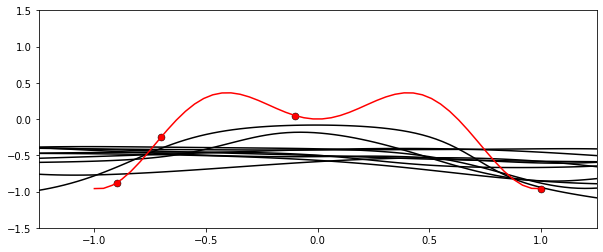

In [8]:
# run predictions
y_pred=[]
for ens in range(0,n_ensembles):
    y_pred.append(NNs[ens].predict(X_val, sess))

# plot predictions
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
for ens in range(0,n_ensembles):
    ax.plot(X_val, y_pred[ens], 'k')
ax.plot(X_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k',markeredgewidth=0.5)
ax.plot(X_ground_truth[:, 0], y_ground_truth, c='r')
ax.set_ylim(-2, 2)
ax.set_ylim(-1.5,1.5)
ax.set_xlim(-1.25,1.25)
plt.savefig('training_short.pdf')

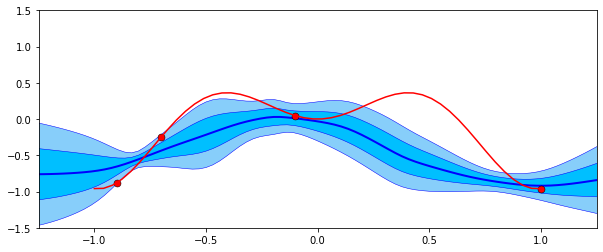

In [156]:
# combine ensembles estimates properly
y_preds = np.array(y_pred)
y_preds = y_preds[:,:,0]
y_pred_mu = np.mean(y_preds,axis=0)
y_pred_std = np.std(y_preds,axis=0, ddof=1)

# add on data noise
y_pred_std = np.sqrt(np.square(y_pred_std) + data_noise)

# plot predictive distribution
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

ax.plot(X_val, y_pred_mu, 'b-', linewidth=2.,label=u'Prediction')
ax.plot(X_val, y_pred_mu + 2 * y_pred_std, 'b', linewidth=0.5)
ax.plot(X_val, y_pred_mu - 2 * y_pred_std, 'b', linewidth=0.5)
ax.plot(X_val, y_pred_mu + 1 * y_pred_std, 'b', linewidth=0.5)
ax.plot(X_val, y_pred_mu - 1 * y_pred_std, 'b', linewidth=0.5)
ax.fill(np.concatenate([X_val, X_val[::-1]]),
         np.concatenate([y_pred_mu - 2 * y_pred_std,
                        (y_pred_mu + 2 * y_pred_std)[::-1]]),
         alpha=1, fc='lightskyblue', ec='None')
ax.fill(np.concatenate([X_val, X_val[::-1]]),
         np.concatenate([y_pred_mu - 1 * y_pred_std,
                        (y_pred_mu + 1 * y_pred_std)[::-1]]),
         alpha=1, fc='deepskyblue', ec='None')

ax.plot(X_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k',markeredgewidth=0.5)


ax.plot(X_ground_truth[:, 0], y_ground_truth,'r')
ax.set_ylim(-1.5,1.5)
ax.set_xlim(-1.25,1.25)
plt.savefig('bayes_short.pdf')

In [157]:
n_epochs = 5000
# do training loop
for ens in range(0,n_ensembles):

    feed_b = {}
    feed_b[NNs[ens].inputs] = X_train
    feed_b[NNs[ens].y_target] = y_train
    print('\nNN:',ens)

    ep_ = 0
    n_epochs_ = np.random.randint(low=n_epochs-1, high=n_epochs)
    print('number of epochs: ', n_epochs_)
    while ep_ < n_epochs_:
        ep_ += 1
        blank = sess.run(NNs[ens].optimizer, feed_dict=feed_b)
        if ep_ % (n_epochs/5) == 0:
            loss_mse = sess.run(NNs[ens].mse_, feed_dict=feed_b)
            loss_anch = sess.run(NNs[ens].loss_, feed_dict=feed_b)
            print('epoch:', ep_, ', mse_', np.round(loss_mse*1e3,3), ', loss_anch', np.round(loss_anch*1e3,3))
            # we're minimising the anchored loss, but it's useful to keep an eye on mse too



NN: 0
number of epochs:  4999
epoch: 1000 , mse_ 0.0 , loss_anch 0.012
epoch: 2000 , mse_ 0.0 , loss_anch 0.011
epoch: 3000 , mse_ 0.0 , loss_anch 0.01
epoch: 4000 , mse_ 0.0 , loss_anch 0.009

NN: 1
number of epochs:  4999
epoch: 1000 , mse_ 0.0 , loss_anch 0.012
epoch: 2000 , mse_ 0.0 , loss_anch 0.012
epoch: 3000 , mse_ 0.0 , loss_anch 0.012
epoch: 4000 , mse_ 0.0 , loss_anch 0.011

NN: 2
number of epochs:  4999
epoch: 1000 , mse_ 0.0 , loss_anch 0.004
epoch: 2000 , mse_ 0.0 , loss_anch 0.004
epoch: 3000 , mse_ 0.0 , loss_anch 0.004
epoch: 4000 , mse_ 0.0 , loss_anch 0.003

NN: 3
number of epochs:  4999
epoch: 1000 , mse_ 0.0 , loss_anch 0.004
epoch: 2000 , mse_ 0.0 , loss_anch 0.004
epoch: 3000 , mse_ 0.0 , loss_anch 0.004
epoch: 4000 , mse_ 0.0 , loss_anch 0.004

NN: 4
number of epochs:  4999
epoch: 1000 , mse_ 0.0 , loss_anch 0.012
epoch: 2000 , mse_ 0.0 , loss_anch 0.012
epoch: 3000 , mse_ 0.0 , loss_anch 0.011
epoch: 4000 , mse_ 0.0 , loss_anch 0.01

NN: 5
number of epochs:  4

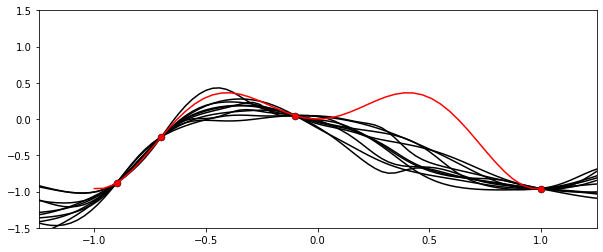

In [158]:
# run predictions
y_pred=[]
for ens in range(0,n_ensembles):
    y_pred.append(NNs[ens].predict(X_val, sess))

# plot predictions
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
for ens in range(0,n_ensembles):
    ax.plot(X_val, y_pred[ens], 'k')
ax.plot(X_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k',markeredgewidth=0.5)
ax.plot(X_ground_truth[:, 0], y_ground_truth, c='r')
ax.set_ylim(-1.5,1.5)
ax.set_xlim(-1.25,1.25)
plt.savefig('training_long.pdf')

Above we have the individual predictions of each NN. We're going to combine them properly now.

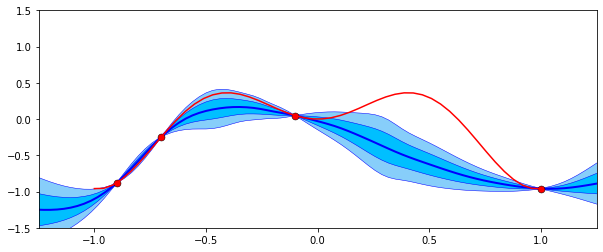

In [159]:
# combine ensembles estimates properly
y_preds = np.array(y_pred)
y_preds = y_preds[:,:,0]
y_pred_mu = np.mean(y_preds,axis=0)
y_pred_std = np.std(y_preds,axis=0, ddof=1)

# add on data noise
y_pred_std = np.sqrt(np.square(y_pred_std) + data_noise)

# plot predictive distribution
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

ax.plot(X_val, y_pred_mu, 'b-', linewidth=2.,label=u'Prediction')
ax.plot(X_val, y_pred_mu + 2 * y_pred_std, 'b', linewidth=0.5)
ax.plot(X_val, y_pred_mu - 2 * y_pred_std, 'b', linewidth=0.5)
ax.plot(X_val, y_pred_mu + 1 * y_pred_std, 'b', linewidth=0.5)
ax.plot(X_val, y_pred_mu - 1 * y_pred_std, 'b', linewidth=0.5)
ax.fill(np.concatenate([X_val, X_val[::-1]]),
         np.concatenate([y_pred_mu - 2 * y_pred_std,
                        (y_pred_mu + 2 * y_pred_std)[::-1]]),
         alpha=1, fc='lightskyblue', ec='None')
ax.fill(np.concatenate([X_val, X_val[::-1]]),
         np.concatenate([y_pred_mu - 1 * y_pred_std,
                        (y_pred_mu + 1 * y_pred_std)[::-1]]),
         alpha=1, fc='deepskyblue', ec='None')

ax.plot(X_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k',markeredgewidth=0.5)


ax.plot(X_ground_truth[:, 0], y_ground_truth,'r')
ax.set_ylim(-1.5,1.5)
ax.set_xlim(-1.25,1.25)
plt.savefig('bayes_long.pdf')

And that's our final predictive distribution! Easy right?

anchoring...
anchoring...
anchoring...
anchoring...
anchoring...
anchoring...
anchoring...
anchoring...
anchoring...
anchoring...


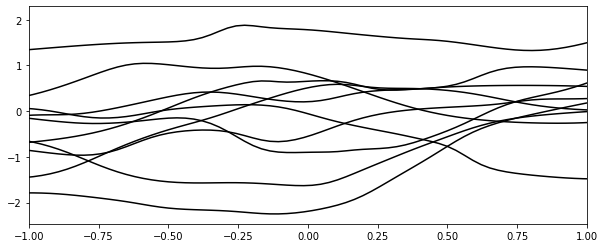

In [122]:
NNnormals=[]
y_prior=[]
tf.reset_default_graph()
sess = tf.Session()

# loop to initialise all ensemble members, get priors
for ens in range(0,n_ensembles):
    NNnormals.append(NN(x_dim, y_dim, hidden_size,
                  init_stddev_1_w, init_stddev_1_b, init_stddev_2_w, n, learning_rate))
    
    # initialise only unitialized variables - stops overwriting ensembles already created
    global_vars = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
    
    # do regularisation now that we've created initialisations
    NNnormals[ens].anchor(sess, lambda_anchor)
    
    # save their priors
    y_prior.append(NNnormals[ens].predict(X_val, sess))
    
# plot priors
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
for ens in range(0,n_ensembles):
    ax.plot(X_val, y_prior[ens], 'k')
ax.set_xlim(-1.25,1.25)
plt.savefig('temp.pdf')

In [ ]:
# do training loop
for ens in range(0,n_ensembles):

    feed_b = {}
    feed_b[NNnormals[ens].inputs] = X_train
    feed_b[NNnormals[ens].y_target] = y_train
    print('\nNN:',ens)

    ep_ = 0
    n_epochs_ = np.random.randint(low=5, high=n_epochs)
    converged = False
    # while ep_ < n_epochs_:
    while  not converged:
        ep_ += 1
        blank = sess.run(NNnormals[ens].optimizer_mse, feed_dict=feed_b)
        if ep_ % (n_epochs/5) == 0:
            loss_mse = sess.run(NNnormals[ens].mse_, feed_dict=feed_b)
            loss_anch = sess.run(NNnormals[ens].loss_, feed_dict=feed_b)
            print('epoch:', ep_, ', mse_', np.round(loss_mse*1e3,3), ', loss_anch', np.round(loss_anch*1e3,3))
            # we're minimising the anchored loss, but it's useful to keep an eye on mse too
            converged = loss_mse<1e-4

In [ ]:
# run predictions
y_pred1=[]
for ens in range(0,n_ensembles):
    y_pred1.append(NNnormals[ens].predict(X_val, sess))

# plot predictions
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
for ens in range(0,n_ensembles):
    ax.plot(X_val, y_pred1[ens], 'k')
    ax.plot(X_val, y_pred[ens], 'g')
ax.plot(X_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k',markeredgewidth=0.5)


ax.plot(X_ground_truth[:, 0], y_ground_truth,'r')
ax.set_ylim(-2, 2)
ax.set_xlim(-1.5, 1.5)


In [ ]:
# combine ensembles estimates properly
y_preds1 = np.array(y_pred1)
y_preds1 = y_preds1[:,:,0]
y_pred_mu1 = np.mean(y_preds1,axis=0)
y_pred_std1 = np.std(y_preds1,axis=0, ddof=1)


# add on data noise
y_pred_std1 = np.sqrt(np.square(y_pred_std1) + data_noise)

# plot predictive distribution
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

ax.plot(X_val, y_pred_mu1, 'b-', linewidth=2.,label=u'Prediction')
ax.plot(X_val, y_pred_mu1 + 2 * y_pred_std1, 'b', linewidth=0.5)
ax.plot(X_val, y_pred_mu1 - 2 * y_pred_std1, 'b', linewidth=0.5)
ax.plot(X_val, y_pred_mu1 + 1 * y_pred_std1, 'b', linewidth=0.5)
ax.plot(X_val, y_pred_mu1 - 1 * y_pred_std1, 'b', linewidth=0.5)
# ax.fill(np.concatenate([X_val, X_val[::-1]]),
#          np.concatenate([y_pred_mu1 - 2 * y_pred_std1,
#                         (y_pred_mu1 + 2 * y_pred_std1)[::-1]]),
#          alpha=1, fc='lightskyblue', ec='None')
# ax.fill(np.concatenate([X_val, X_val[::-1]]),
#          np.concatenate([y_pred_mu1 - 1 * y_pred_std1,
#                         (y_pred_mu1 + 1 * y_pred_std1)[::-1]]),
#          alpha=1, fc='deepskyblue', ec='None')

ax.plot(X_val, y_pred_mu, 'g-', linewidth=2.,label=u'Prediction')
ax.plot(X_val, y_pred_mu + 3 * y_pred_std, 'g:', linewidth=0.7)
ax.plot(X_val, y_pred_mu - 3 * y_pred_std, 'g:', linewidth=0.7)
ax.plot(X_val, y_pred_mu + 1 * y_pred_std, 'g:', linewidth=0.7)
ax.plot(X_val, y_pred_mu - 1 * y_pred_std, 'g:', linewidth=0.7)



ax.plot(X_train[:,0], y_train, 'r.', markersize=14,
        markeredgecolor='k',markeredgewidth=0.5)

ax.plot(X_ground_truth[:, 0], y_ground_truth,'r')
ax.set_ylim(-1.5,1)
ax.set_xlim(-1.5, 1.5)

